### A serial robot
- A revolute hip joint.
- With a extendable leg (a slide joint) for jumping.


In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sympy as sm
import sympy.physics.mechanics as me

import interpolation
from integrate import integrate_eom


%config InlineBackend.figure_formats = ['svg']
me.functions.mechanics_printing(use_latex="mathjax", latex_mode="equation")

In [2]:
import importlib

importlib.reload(interpolation)

<module 'interpolation' from 'd:\\interpolation.py'>

In [3]:
from matplotlib.patches import Arc
from matplotlib.transforms import Bbox, IdentityTransform, TransformedBbox


class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])

(-0.2, 1.15)

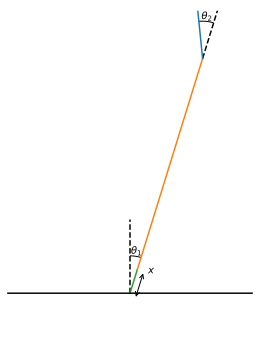

In [14]:
fig, ax = plt.subplots(figsize=(5, 6))
ax.set_aspect('equal')
ax.set_frame_on(False)
plt.axis('off')

th1 = -0.3
th2 = 0.4

len_a = 1.0
len_b = 0.2
val_x = 0.1

ax.plot([0, -val_x * np.sin(th1)], [0, val_x * np.cos(th1)], c='C2')
ax.plot([-val_x * np.sin(th1), -len_a * np.sin(th1)], [val_x * np.cos(th1), len_a * np.cos(th1)], c='C1')
ax.plot([0, 0], [0, 0.3], '--', c='k', zorder=-5)

ax.plot([-len_a * np.sin(th1), -len_a * np.sin(th1) - len_b * np.sin(th1 + th2)], [len_a * np.cos(th1), len_a * np.cos(th1) + len_b * np.cos(th1 + th2)], c='C0')
ax.plot([-len_a * np.sin(th1), -(len_a + 0.3) * np.sin(th1)],
        [len_a * np.cos(th1), (len_a + 0.3) * np.cos(th1)],
        '--', c='k', zorder=-5)

ax.plot([-2, 2], [0, 0], c='k')

am1 = AngleAnnotation(
    (0, 0),
    (-0.2 * np.sin(th1), 0.2 * np.cos(th1)),
    (0, 0.2),
    ax=ax, size=75, text=r"$\theta_1$", textposition="outside",
)

am2 = AngleAnnotation(
    (-len_a * np.sin(th1), len_a * np.cos(th1)),
    (-(len_a + 0.2) * np.sin(th1), (len_a + 0.2) * np.cos(th1)),
    (-len_a * np.sin(th1) - 0.2 * np.sin(th1 + th2),
     len_a * np.cos(th1) + 0.2 * np.cos(th1 + th2)),
    ax=ax, size=75, text=r"$\theta_2$", textposition="outside",
)

ax.annotate(
    "",
    xy=(0.025 * np.cos(th1), 0.05 * np.sin(th1)), 
    xytext=(0.025 * np.cos(th1) - val_x * np.sin(th1),
            0.05 * np.sin(th1) + val_x * np.cos(th1)),
    arrowprops=dict(arrowstyle="<->", connectionstyle="arc3",
                    shrinkA=.0, shrinkB=.0),
)
ax.text(0.025 * np.cos(th1) - val_x * np.sin(th1) + 0.02,
        0.05 * np.sin(th1) + val_x * np.cos(th1),
        r'$x$')

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.2, 1.15)


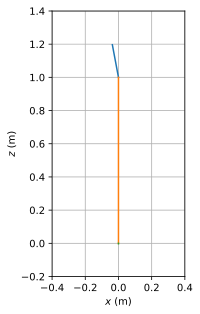

In [17]:
import matplotlib.animation as animation


fig, ax = plt.subplots()

ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$z$ (m)')
ax.grid()

ax.set_aspect('equal')
ax.set_xlim(-0.4, 0.4)
ax.set_ylim(-0.2, 1.4)


t = 0
def points(t):
    th1 = np.sin(t) * 0.6
    p1 = [len_b * np.sin(th1), len_a + len_b * np.cos(th1)]
    p2 = [0, len_a]
    p3 = [0, 0]
    p4 = [0, -val_x * (1 - np.cos(t)) / 2]

    return p1, p2, p3, p4


ps = points(0)

lines = []

for pa, pb in zip(ps[:-1], ps[1:]):
    line, = ax.plot([pa[0], pb[0]], [pa[1], pb[1]])
    lines.append(line)


def animate(i):
    t = i * np.pi / 10
    ps = points(t)

    for line, (pa, pb) in zip(lines, zip(ps[:-1], ps[1:])):
        line.set_data([pa[0], pb[0]], [pa[1], pb[1]])
    
    return lines


ani = animation.FuncAnimation(fig, animate, frames=20, interval=50, blit=True)
ani.save('robot_joints.gif', writer='pillow')

In [5]:
# 2D problem or is it a 4D problem?
th1, th2 = me.dynamicsymbols('theta_1 theta_2', real=True)

# This totally makes sense to use a SymPy symbol for an actuation
# since you don't need to consider the time derivative of this quantity.
uth2 = sm.symbols('u_{\\theta_2}', real=True)

dth1 = th1.diff()
dth2 = th2.diff()
ddth1 = dth1.diff()
ddth2 = dth2.diff()

# Three reference frames.
# Reference frame A and B are attached to robot links at their respective CoM.
N = me.ReferenceFrame('N')
NA = me.ReferenceFrame('A')
NB = me.ReferenceFrame('B')

NA.orient_axis(N, N.y, th1)
NB.orient_axis(NA, NA.y, th2)

# Physical parameters.
la, lb, ma, mb, g = sm.symbols('l_a l_b m_a m_b g', real=True, positive=True)
Ia, Ib = sm.symbols('I_a I_b', real=True, positive=True)

# Define the origin in the frame N.
O = me.Point('O')
O.set_vel(N, 0 * N.x)

# These points are the centers of mass of two links.
Pa = O.locatenew('P_a', (la / 2) * NA.z)
Pb = O.locatenew('P_b', la * NA.z + (lb / 2) * NB.z)

Ba = me.RigidBody('B_a', Pa, N, ma, (me.inertia(NA, Ia, Ia, 0), Pa))
Bb = me.RigidBody('B_b', Pb, N, mb, (me.inertia(NB, Ib, Ib, 0), Pb))

# Gravitational potential energy.
Ba.potential_energy = Pa.pos_from(O).dot(N.z) * ma * g
Bb.potential_energy = Pb.pos_from(O).dot(N.z) * mb * g

- Note that `MutableDenseMatrix.simplify` does not return anything. It modifies the matrix.

In [6]:
L = me.Lagrangian(N, Ba, Bb)

LM = me.LagrangesMethod(L, [th1, th2])
eom = LM.form_lagranges_equations()
eom.simplify()

# Unfortunately, `MutableDenseMatrix.collect` does not performe element-wise operations.
for (i, j), element in eom.todok().items():
    eom[i, j] = element.collect(ddth1).collect(ddth2).collect(dth1 * dth2).collect(sm.sin(th1))


In [7]:
# Actuation u(t), which is a dynamic symbol, is added to the equations of motion.
eom -= sm.Matrix([[0], [uth2]])

In [8]:
eom

⎡                                                                2             ↪
⎢  g⋅lₐ⋅mₐ⋅sin(θ₁)   g⋅m_b⋅(2⋅lₐ⋅sin(θ₁) + l_b⋅sin(θ₁ + θ₂))   lₐ ⋅mₐ⋅θ₁̈   m_b ↪
⎢- ─────────────── - ─────────────────────────────────────── + ───────── + ─── ↪
⎢         2                             2                          4           ↪
⎢                                                                              ↪
⎢                                                          ⎛                   ↪
⎢                                                  l_b⋅m_b⋅⎝-2⋅g⋅sin(θ₁ + θ₂)  ↪
⎢                                                  ─────────────────────────── ↪
⎣                                                                              ↪

↪  ⎛                                             2   ⎛                      2⎞ ↪
↪ ⋅⎝-4⋅lₐ⋅l_b⋅sin(θ₂)⋅θ₁̇⋅θ₂̇ - 2⋅lₐ⋅l_b⋅sin(θ₂)⋅θ₂̇  + ⎝2⋅lₐ⋅l_b⋅cos(θ₂) + l_b ⎠ ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪                      

In [9]:
physical_params = {
    g: 9.8,
    la: 1,
    lb: 0.2,
    ma: 1,
    mb: 5,
    Ia: 1,
    Ib: 5,
}

In [10]:
# `sol` is a function of (th1, th2, dth1, dth2, u), which are subsituted by all SymPy symbols below.
# Are you surprised that sympy.solve can solve equations for dynamic symbols?
#     Actually, ddth1, ddth2 may be some kind of SymPy symbols.
# Note that ddth1 and ddth2 are dynamic symbols not SymPy symbols.
sol = sm.solve(
    eom.subs(physical_params),
    [ddth1, ddth2],
)

# Some simplifications. Do they work?
sol = {k: v.simplify().trigsimp().collect(sm.sin(th2)) for k, v in sol.items()}


### First example: integrating the EoM (free fall).
- No actuations $u_{\theta_2} = 0$ and $x(t) = 0$.
- Using `scipy.integrate.solve_ivp`.
    - Conveniently, the EoM is smooth (as functions of $y$ and $u_{\theta_2}$) through the region.
    - You can use only single segment.

In [11]:
state_vec = [th1, th2, dth1, dth2]
y0 = (0, 0.05, 0, 0)


def th2_actuation(t):
    """Calculates u_th2(t)

    Parameters
    ----------
    t (float): time.
    """
    return 0


def f(t, y):
    """
    Calculate dy / dt = f(t, y),
    where y = (\\theta_1, \\theta_2, \\dot{\\theta_1}, \\dot{\\theta_2}).

    Parameters
    ----------
    t (float): time.
    y (tuple): y is the values of (th1, th2, dth1, dth2).
    """
    # Assumes that tau(t) = 0.
    ath2 = th2_actuation(t)

    return np.asarray([
        y[2],
        y[3],
        sol[ddth1].subs({**{k: v for k, v in zip(state_vec, y)}, uth2: ath2}),
        sol[ddth2].subs({**{k: v for k, v in zip(state_vec, y)}, uth2: ath2}),
    ])


tf = 0.1
# The time step is 25 ms.
t_eval = np.linspace(0, tf, 41)

# Integrate the equations of motion from 0 ms to 100 ms.
traj = sp.integrate.solve_ivp(f, (0, tf), y0, t_eval=t_eval)

(0.0, 0.1)

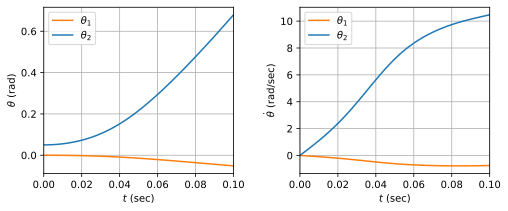

In [12]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=0.35)

ax0.plot(traj.t, traj.y[0], c='C1', label=r'$\theta_1$')
ax0.plot(traj.t, traj.y[1], c='C0', label=r'$\theta_2$')

ax0.legend()
ax0.set_xlabel(r'$t$ (sec)')
ax0.set_ylabel(r'$\theta$ (rad)')
ax0.grid()
ax0.set_xlim(traj.t[0], traj.t[-1])

ax1.plot(traj.t, traj.y[2], c='C1', label=r'$\theta_1$')
ax1.plot(traj.t, traj.y[3], c='C0', label=r'$\theta_2$')

ax1.legend()
ax1.set_xlabel(r'$t$ (sec)')
ax1.set_ylabel(r'$\dot{\theta}$ (rad/sec)')
ax1.grid()
ax1.set_xlim(traj.t[0], traj.t[-1])

#### Visualizing motions.
- Line plots fades away.

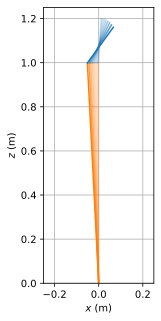

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

alpha = 1

for i, y in enumerate(traj.y.T[::-4]):
    th1_val, th2_val, *_ = y
    x_val = 0

    len_a, len_b = physical_params[la], physical_params[lb]
    p_x = [x_val * np.sin(th1_val), x_val * np.cos(th1_val)]
    p_a = [(len_a + x_val) * np.sin(th1_val),
           (len_a + x_val) * np.cos(th1_val)]
    p_b = [(len_a + x_val) * np.sin(th1_val) + len_b * np.sin(th1_val + th2_val),
           (len_a + x_val) * np.cos(th1_val) + len_b * np.cos(th1_val + th2_val)]

    ax.plot([0, p_x[0]], [0, p_x[1]], c='C2', alpha=alpha)
    ax.plot([p_x[0], p_a[0]], [p_x[0], p_a[1]], c='C1', alpha=alpha)
    ax.plot([p_a[0], p_b[0]], [p_a[1], p_b[1]], c='C0', alpha=alpha)
    alpha *= 0.75

ax.grid()
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$z$ (m)')

ax.set_xlim(-0.25, 0.25)
ax.set_ylim(0, 1.25)
ax.set_aspect('equal')


### Trajectory $\theta_2(t)$ generations.
- Formulating as a convex optimization problem.
- I got oscillatory interpolations with cubic splines.
    - L2 penalties are simple and easy to implement for cubic splines.
- L1 penalty prevents oscillatory behaviors?
    - These interpolations will be piecesewise smooth.

(-0.3149995607665671, 0.014999569287748461)

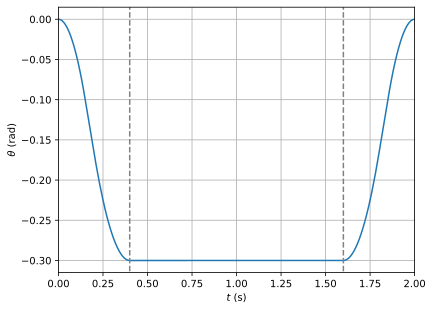

In [ ]:
tf = 2.0
n = 40
dt = tf / n

ts = np.linspace(0, tf, n + 1)
ss, vels, accs = interpolation.path(ts)

constraints = [
    ss[0] == 0, vels[0] == 0,
    vels[8] == 0, ss[8] == -0.3,
    ss[-9] == -0.3, vels[-9] == 0,
    ss[-1] == 0., vels[-1] == 0,
]

# Do I really need this complicated cost function?
prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(accs[1:] - accs[:-1])) +
                              cp.sum(accs**2) * 0.01 +
                              cp.sum(cp.abs(vels)) * 10),
                              constraints)
prob.solve()

fig, ax = plt.subplots()

# ax.plot(ts, ss.value)

int_ts = np.linspace(0, tf, 201)
ax.plot(int_ts, [interpolation.pos(t, ts, ss, vels, accs) for t in int_ts])

ax.vlines([8 * dt, (n - 8) * dt], ymin=-10, ymax=10,
          colors='grey', linestyle='--')

ax.grid()
ax.set_xlabel(r'$t$ (s)')
ax.set_ylabel(r'$\theta$ (rad)')

ax.set_xlim(0, tf)

a, b = np.min(ss.value), np.max(ss.value)
ax.set_ylim(1.05 * a - 0.05 * b, 1.05 * b - 0.05 * a)

(0.0, 2.0)

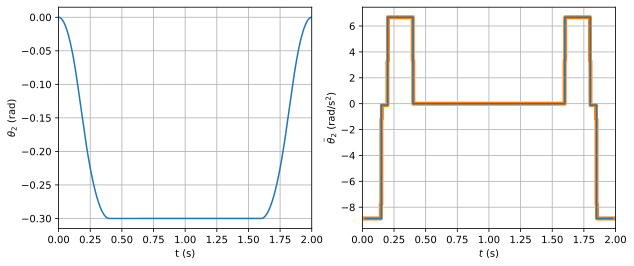

In [ ]:
int_ts = np.linspace(0, tf, 501)
ys = [interpolation.pos(t, ts, ss, vels, accs) for t in int_ts]

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax.plot(int_ts, ys)

ax.grid()

ax.set_xlabel('t (s)')
ax.set_ylabel(r'$\theta_2$ (rad)')
ax.set_xlim(0, tf)

# Just to make sure S and V matrices are correct.
ax2.step((ts[:-1] + ts[1:]) / 2, accs.value, where='mid')
ax2.step(int_ts[1:-1], np.diff(ys, 2) / (int_ts[1] - int_ts[0])**2, lw=4, zorder=-10, where='mid')
ax2.grid()

ax2.set_xlabel(r'$t$ (s)')
ax2.set_ylabel(r'$\ddot{\theta}_2$ (rad/s$^2$)')

ax2.set_xlim(0, tf)


### Solving the EoM algebraically.
- Two generalized forces $\ddot{\theta}_1(y, u_{\theta_3})$ and $\ddot{\theta}_2(y, u_{\theta_2})$ are given as functions of $y$ and $u_{\theta_2}$ in the EoM.
- Six dynamic symbols $\theta_1(t)$, $\theta_2(t)$, $\dot{\theta}_1(t)$, $\dot{\theta}_2(t)$, $\ddot{\theta}_1(t)$, $\ddot{\theta}_2(t)$ and one actuation are involved.
    - In general, when 5 of 7 are specified, the rest 2 of them can be calculated.
    - If actuations are involved. these or accelerations need to be specified.

In [16]:
# In this example, th2(t) is specified.
sol_th2 = sm.solve(
    eom.subs(physical_params),
    [ddth1, uth2]
)

sol_th2 = {k: v.simplify().trigsimp() for k, v in sol_th2.items()}

- Note that `scipy.integrate.solve_ivp` assumes the smooth functions.
- But the trajectorys are only C1 (or C2) continuous.

In [17]:
# Integrate the equations of motion segment by segments.
y0 = np.zeros(4)
ys = [y0, ]

for idx, (a, b) in enumerate(zip(ts[:-1], ts[1:])):
    def f(_, y):
        ath2 = accs.value[idx]

        return np.asarray([
            y[2],
            y[3],
            sol_th2[ddth1].subs({**{a: b for a, b in zip(state_vec, y)}, ddth2: ath2}),
            ath2,
        ])

    traj = sp.integrate.solve_ivp(f, (a, b), ys[-1], t_eval=np.linspace(a, b, 11))
    ys.append(traj.y[:, -1])

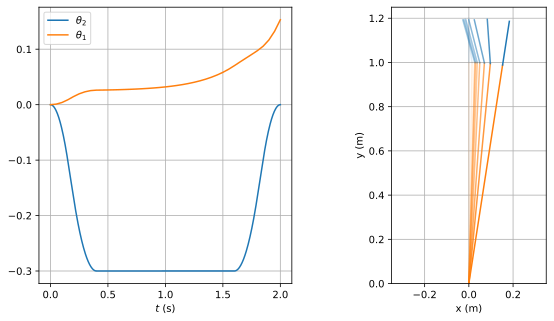

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax.plot(int_ts, [interpolation.pos(t, ts, ss, vels, accs) for t in int_ts],
        label=r'$\theta_2$')
# ax.plot(t_eval, traj_1.y[1], label=r'$\theta_2$')
ax.plot(ts, [y[0] for y in ys], label=r'$\theta_1$')
# ax.plot(ts, [y[1] for y in ys], '.', label=r'$\theta_2$')

ax.legend()
ax.grid()
ax.set_xlabel(r'$t$ (s)')

def draw_ax2(ax):
    alpha = 1
    for i, y in enumerate(ys[::-4]):
        len_a, len_b = physical_params[la], physical_params[lb]
        p_a = [len_a * np.sin(y[0]), len_a * np.cos(y[0])]
        p_b = [len_a * np.sin(y[0]) + len_b * np.sin(y[0] + y[1]),
               len_a * np.cos(y[0]) + len_b * np.cos(y[0] + y[1])]
        
        ax.plot([0, p_a[0]], [0, p_a[1]], c='C1', alpha=alpha)
        ax.plot([p_a[0], p_b[0]], [p_a[1], p_b[1]], c='C0', alpha=alpha)
        alpha *= 0.8
    
    ax.grid()
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    
    ax.set_xlim(-0.35, 0.35)
    ax.set_ylim(0, 1.25)
    ax.set_aspect('equal')

draw_ax2(ax2)

- You can see that the extension of the hip joint pushes the robot towards the vertical position.

### Energy dissipations and transfers using $\theta_2$ actuations.
- Its underlying mechanism is similar to that of a swing set.
- Lyapunov theory can give necessary conditions for stabilizing controller?
    - $L = T - V$
    - A monotonically decreasing lagrangian suggests a stabilizing trajectory.

#### Hip joint extension at different moments.
- The initial state $y_i = (-1., 0.6, 2.95, 0.)$.
- If the hip joint $\theta_2$ is extended (from 0.6 to 0.0) early, it slows down $\theta_1$.
- Its effect does not seems to be dramatic.
    - Does it mean a very small window of reachability region in the phase space?

(-1.0, 0.0)

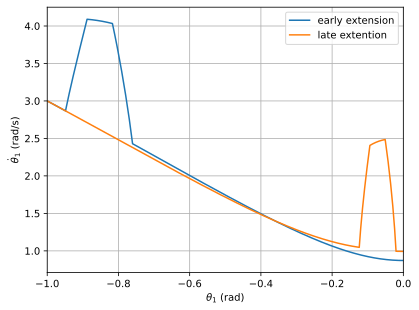

In [25]:
# Two sets of constraints give different interpolations.
def gen_constraints1(ss, vels, accs):
    return [
        ss[0] == 0.6, vels[0] == 0,
        ss[1] == 0.6, vels[1] == 0,
        ss[4] == 0.0, vels[4] == 0,
        ss[-1] == 0., vels[-1] == 0,
    ]


def gen_constraints2(ss, vels, accs):
    return [
        ss[0] == 0.6, vels[0] == 0,
        ss[-12] == 0.6, vels[-12] == 0,
        ss[-9] == 0.0, vels[-9] == 0,
        ss[-1] == 0., vels[-1] == 0,
    ]


def event(t, y):
    return y[0]


event.terminal = True

tf = 0.7
n = 40
dt = tf / n

fig, ax = plt.subplots()

for gen_constraints, label in zip([gen_constraints1, gen_constraints2],
                                  ['early extension', 'late extention']):
    ts = np.linspace(0, tf, n + 1)
    ss, vels, accs = interpolation.path(ts)

    prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(accs))),
                      gen_constraints(ss, vels, accs))
    prob.solve()

    # Integrate the equations of motion segment by segment.
    xs = [[0,]]
    ys = [np.asarray([[-1., ], [0.6, ], [3, ], [0., ]])]

    for idx, (a, b) in enumerate(zip(ts[:-1], ts[1:])):
        def f(_, y):
            ath2 = accs.value[idx]

            return np.asarray([
                y[2],
                y[3],
                sol_th2[ddth1].subs({**{a: b for a, b in zip(state_vec, y)},
                                     **{ddth2: ath2}}),
                ath2,
            ])

        traj = sp.integrate.solve_ivp(f, (a, b), ys[-1][:, -1],
                                      t_eval=np.linspace(a, b, 11),
                                      events=event)
        xs.append(traj.t[1:])
        ys.append(traj.y[:, 1:])

        if traj.status == 1:
            break

    xs = np.concatenate(xs)
    ys = np.concatenate(ys, axis=1)
    ax.plot(ys[0], ys[2], label=label)

ax.legend()
ax.grid()
# ax.set_xlabel(r'$t$ (s)')
ax.set_xlabel(r'$\theta_1$ (rad)')
ax.set_ylabel(r'$\dot{\theta}_1$ (rad/s)')

ax.set_xlim(-1, 0)


(-1.0, 0.0)

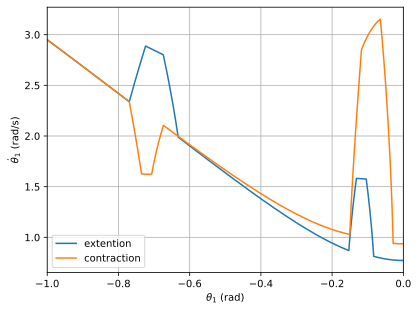

In [26]:
tf = 0.7
n = 40
dt = tf / n


def gen_constraints1(ss, vels, accs):
    return [
    ss[0] == 0.6, vels[0] == 0,
    ss[5] == 0.6, vels[5] == 0,
    ss[8] == 0.3, vels[8] == 0,
    ss[-12] == 0.3, vels[-12] == 0,
    ss[-9] == 0, vels[-9] == 0,
    ss[-1] == 0., vels[-1] == 0,
]


def gen_constraints2(ss, vels, accs):
    return [
    ss[0] == 0.6, vels[0] == 0,
    ss[5] == 0.6, vels[5] == 0,
    ss[8] == 0.9, vels[8] == 0,
    ss[-12] == 0.9, vels[-12] == 0,
    ss[-9] == 0, vels[-9] == 0,
    ss[-1] == 0., vels[-1] == 0,
]


fig, ax = plt.subplots()

for gen_cons, label in zip([gen_constraints1, gen_constraints2],
                           ['extention', 'contraction']):
    ts = np.linspace(0, tf, n + 1)
    ss, vels, accs = interpolation.path(ts)

    prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(accs))),
                      gen_cons(ss, vels, accs))
    prob.solve()
    
    # Integrate the equations of motion segment by segment.
    xs = [[0,]]
    ys = [np.asarray([[-1., ], [0.6, ], [2.95, ], [0., ]])]

    for idx, (a, b) in enumerate(zip(ts[:-1], ts[1:])):
        def f(_, y):
            ath2 = accs.value[idx]

            return np.asarray([
                y[2],
                y[3],
                sol_th2[ddth1].subs({**{a: b for a, b in zip(state_vec, y)},
                                     **{ddth2: ath2}}),
                ath2,
            ])

        traj = sp.integrate.solve_ivp(f, (a, b), ys[-1][:, -1],
                                      t_eval=np.linspace(a, b, 11),
                                      events=event)
        xs.append(traj.t[1:])
        ys.append(traj.y[:, 1:])

        if traj.status == 1:
            break

    xs = np.concatenate(xs)
    ys = np.concatenate(ys, axis=1)
    # ax.plot(xs, ys[0])
    ax.plot(ys[0], ys[2], label=label)

ax.legend()
ax.grid()
# ax.set_xlabel(r'$t$ (s)')
ax.set_xlabel(r'$\theta_1$ (rad)')
ax.set_ylabel(r'$\dot{\theta}_1$ (rad/s)')

ax.set_xlim(-1, 0)

- Early and larger extension slow down the $\theta_1$ motions.
- What the robot can control is the amount of deccelerations.

### Backtracking motion planning
- For the fianl state $y_f = (0, 0, 0, 0)$.

### A rechability problem for the last stage of the jump.
- This is a question about
    - Whether the robot has enough momentum in $\dot{\theta}_1$ to reach to the equilibrium point.
    - How to slow down the motion of $\theta_1$!
- The classical equations of motion are time-reversal symmetric.
    - Once  you know the final state (or initial state), you can get the whole trajectory backward (or forward).
- Let $y_f = (\theta_1 = 0, \theta_2 = 0, \dot{\theta}_1 = 0, \dot{\theta}_2 = 0)$ be the final state of the trajectory.
- Samples the initial states by choose different trajectories of $\theta_2(t)$.
    - Make sure that $(\theta_2 = 0.6, \dot{\theta}_2=0)$.
       - That simplifies the designations of the initial states $y_i$.
       - If it is not enforced, 4 dimensional region needs to be specified.

(0.0, 1.75)

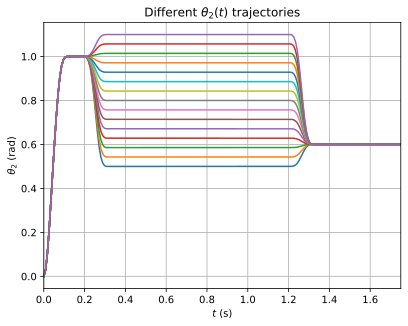

In [27]:
tf = 1.75

th2_trajs = []

fig, ax = plt.subplots()

for bend_amp in np.linspace(0.5, 1.1, 15):
    ts = np.linspace(0, tf, 46)
    ss, vels, accs, jerks = interpolation.path_jerk(ts)

    constraints = [
            ss[0] == 0, vels[0] == 0,
            ss[3] == 1.0, vels[3] == 0,
            ss[5] == 1.0, vels[5] == 0,
            ss[8] == bend_amp, vels[8] == 0,
            ss[-15] == bend_amp, vels[-15] == 0,
            ss[-12] == 0.6, vels[-12] == 0,
            ss[-1] == 0.6, vels[-1] == 0,
        ]

    prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(accs))), constraints)
    prob.solve()

    th2_trajs.append([ts, ss, vels, accs, jerks])

    int_ts = np.linspace(0, tf, 201)
    ax.plot(int_ts, [interpolation.pos(t, ts, ss, vels, accs, jerks) for t in int_ts])

ax.grid()
ax.set_xlabel(r'$t$ (s)')
ax.set_ylabel(r'$\theta_2$ (rad)')
ax.set_title(r'Different $\theta_2(t)$ trajectories')

ax.set_xlim(0, tf)

- Integrating the EoM for each of $\theta_2(t)$ trajectories.
- $\theta_1 = -0.44$ is the terminating condition.

In [28]:
def event(_, y):
    return y[0] - ()


def event(t, y):
        return y[0] - (-0.22)


event.terminal = True
event.direction = -1

trajs = []

for ts, ss, vels, accs, jerks in th2_trajs:
    # Integrate the equations of motion segment by segment.
    xs = [[0,]]
    ys = [np.zeros((4, 1))]

    for idx, (a, b) in enumerate(zip(ts[:-1], ts[1:])):
        def f(t, y):
            ath2 = interpolation.acc(t, ts, ss, vels, accs, jerks)

            return np.asarray([
                y[2],
                y[3],
                sol_th2[ddth1].subs({**{a: b for a, b in zip(state_vec, y)},
                                     **{ddth2: ath2}}),
                ath2,
            ])

        traj = sp.integrate.solve_ivp(f, (a, b), ys[-1][:, -1],
                                      t_eval=np.linspace(a, b, 21),
                                      events=event)
        xs.append(traj.t[1:])
        ys.append(traj.y[:, 1:])

        if traj.status == 1:
             break

    xs = np.concatenate(xs)
    ys = np.concatenate(ys, axis=1)
    trajs.append((xs, ys))

- A density plot from irregular grid points would be necessary to show the reachable set?

(-0.49, -0.45)

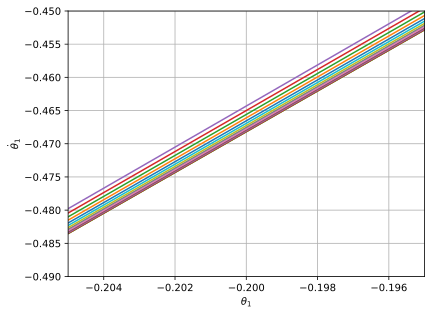

In [26]:
fig, ax = plt.subplots()

for xs, ys in trajs:
    # Once t >= 1.2, th2 = 0.6 and dth2 = 0.0.
    flag = (xs >= 1.4) & (ys[0] < -0.18)

    # ax.plot(xs, ys[0])
    ax.plot(ys[0][flag], ys[2][flag])

ax.grid()
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\dot{\theta}_1$')

# ax.set_xlim(-0.43, -0.42)
# ax.set_ylim(-1.17, -1.12)
# ax.set_xlim(-0.43, -0.39)
# ax.set_ylim(-1.17, -1.0)

ax.set_xlim(-0.205, -0.195)
ax.set_ylim(-0.49, -0.45)

- The reachable region is narrow. Small window in $\dot{\theta}_1$.
    - I can see that this is a difficult motion control problem.
- Can the robot reach to the state $y = (-0.20, 0.6, 0.466, 0)$ after the landing?

#### Visualizing the motion planning for the last step.
- If $\dot{\theta}_1$ is greater in magnitude, the amount of contraction needs to be reduced for greater decelerations of the motion of $\theta_1$.
    - Assuming that initially $\theta_1=-0.2$, $\theta_2=0.6$, and $\dot{\theta}_2=0$.

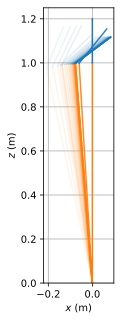

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))

alpha = 1

for y in trajs[-3][1][:, :-10].T[::32]:
    len_a, len_b = physical_params[la], physical_params[lb]
    p_a = [len_a * np.sin(y[0]), len_a * np.cos(y[0])]
    p_b = [len_a * np.sin(y[0]) + len_b * np.sin(y[0] + y[1]), len_a * np.cos(y[0]) + len_b * np.cos(y[0] + y[1])]

    ax.plot([0, p_a[0]], [0, p_a[1]], c='C1', alpha=alpha)
    ax.plot([p_a[0], p_b[0]], [p_a[1], p_b[1]], c='C0', alpha=alpha)
    alpha *= 0.9

ax.grid()
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$z$ (m)')

# ax.set_xlim(-0.25, 0.25)
ax.set_ylim(0, 1.25)
ax.set_aspect('equal')

In [186]:
trajs[-3][1][:, -11]

array([-4.10749882e-01,  6.00000008e-01, -1.09691453e+00,  1.46076648e-07])

In [ ]:
y0 = []